In [17]:
import os
import numpy as np
import pandas as pd
import sys

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

import xgboost as xgb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sys.path.append(os.path.dirname(os.getcwd()))
from tools.utils import encode_all_structures, Encoding

In [18]:
DATA_DIR = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())), "data/"
)

# Loading Data

In [19]:
encoding = Encoding.COLUMN_MASS

df = pd.read_csv(os.path.join(DATA_DIR, "data.csv"), index_col=0, na_filter= False)
df = encode_all_structures(df, encoding)

In [20]:
cols_raw = list(df.columns)
cols_trash = ["structure", 'converged', "n_iterations", "delta_E", "fermi", "total_energy"]
cols_independent = ['time']
cols_drop = cols_trash + cols_independent

cols_dependent = cols_raw.copy()
for element in cols_drop:
    cols_dependent.remove(element)

In [21]:
X_raw = df[cols_dependent][df["converged"]]
y_raw = np.abs(df[cols_independent][df["converged"]]).squeeze()

In [22]:
X_raw.describe()

,ecutrho,k_density,ecutwfc,accuracy,Lant,PTC1,PTC2,PTC3,PTC4,PTC5,...,PTC9,PTC10,PTC11,PTC12,PTC13,PTC14,PTC15,PTC16,PTC17,PTC18
count,56309.000000,56309.000000,56309.000000,5.630900e+04,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,...,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,56309.000000,56309.0
mean,244.850734,5.839848,58.411977,3.242029e-10,0.149177,0.031173,0.043240,0.022388,0.023752,0.031421,...,0.054770,0.056758,0.062610,0.037938,0.046023,0.049814,0.091317,0.060502,0.024574,0.0
std,89.258136,2.830937,24.136707,2.832151e-10,0.287443,0.133047,0.133163,0.107280,0.107936,0.123172,...,0.183287,0.190763,0.188731,0.146247,0.161086,0.138497,0.206135,0.166459,0.127998,0.0
min,100.000000,2.000000,20.000000,1.600000e-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,180.000000,4.000000,40.000000,7.900000e-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,260.000000,6.000000,60.000000,2.400000e-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,340.000000,8.000000,80.000000,5.300000e-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,380.000000,10.000000,100.000000,1.000000e-09,0.924714,0.733997,0.732088,0.741626,0.841555,0.885522,...,0.876908,0.983118,0.899810,0.803422,0.967155,0.808676,0.918451,0.839999,0.833172,0.0


# Train-Test-Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    random_state=42
)

# Model definitions

### Linear Model with feature augmentation

In [24]:
linear_augmented_model = Pipeline([
    ('scaler_init', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2)),
    ('scaler_final', StandardScaler()),
    ('regressor', LinearRegression()),
])

### Random forest

In [25]:
rf_model = RandomForestRegressor(random_state=0)

### Gradient Boosting

In [26]:
gb_model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

### XGBoost

In [27]:
xgb_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0, tree_method="gpu_hist")

### Packing them together to reduce code size

In [28]:
models = {
    "Augmented Linear Regression": linear_augmented_model,
    "Random Forest": rf_model,
    # "Gradient Boosting": gb_model,
    "XGBoost": xgb_model,
}

# Model training

In [29]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print("Done!\n")

Training Augmented Linear Regression...
Done!

Training Random Forest...
Done!

Training XGBoost...
Done!



# Model evaluation

In [30]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mae_test = mean_absolute_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    print(f"MAE:\ttrain:{mae_train:.4E}\ttest:{mae_test:.4E}")

    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Augmented Linear Regression...
MSE:	train:1.0955E+10	test:9.2995E+09
MAE:	train:5.0332E+04	test:4.9583E+04
MAPE:	train:1.4760E+01	test:1.4225E+01
Done!

Evaluating Random Forest...
MSE:	train:1.2386E+08	test:1.1043E+09
MAE:	train:2.4025E+03	test:6.6378E+03
MAPE:	train:2.8951E-02	test:7.9429E-02
Done!

Evaluating XGBoost...
MSE:	train:5.8933E+07	test:1.1079E+09
MAE:	train:3.3744E+03	test:8.3150E+03
MAPE:	train:3.0526E-01	test:4.2361E-01
Done!



# Visualization

Text(0.5, 0, 'ecutwfc')

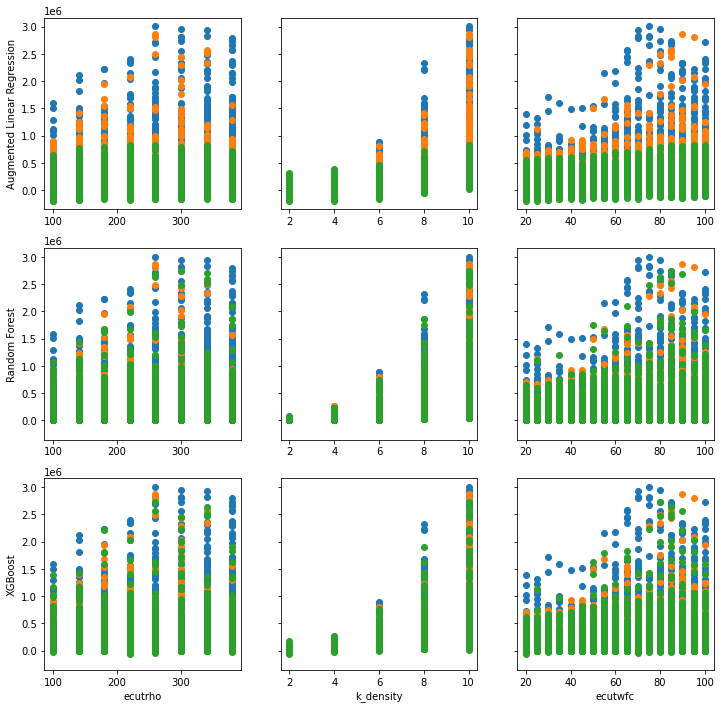

In [31]:
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], y_train)
        ax[j,i].scatter(X_test[col], y_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')

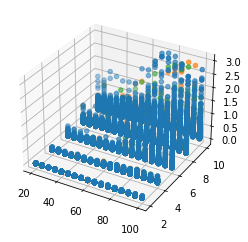

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['ecutwfc'], X_train['k_density'], y_train)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], y_test)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], rf_model.predict(X_test))